<a href="https://colab.research.google.com/github/eliasingi12/DEEP_U-net_Project/blob/master/DEEP_run_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!curl -L -o DRIVE.zip "https://drive.google.com/uc?export=download&id=1aSJuBxtklXelBJEt-kvG32QQYO1BIQyP"
!unzip DRIVE.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    270      0 --:--:--  0:00:01 --:--:--   270
100 28.6M    0 28.6M    0     0  14.7M      0 --:--:--  0:00:01 --:--:-- 14.7M
Archive:  DRIVE.zip
replace DRIVE/test/mask/12_test_mask.gif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: DRIVE/test/mask/12_test_mask.gif  
 extracting: DRIVE/test/mask/10_test_mask.gif  
 extracting: DRIVE/test/mask/08_test_mask.gif  
 extracting: DRIVE/test/mask/06_test_mask.gif  
 extracting: DRIVE/test/mask/04_test_mask.gif  
 extracting: DRIVE/test/mask/01_test_mask.gif  
 extracting: DRIVE/test/mask/05_test_mask.gif  
 extracting: DRIVE/test/mask/13_test_mask.gif  
 extracting: DRIVE/test/mask/02_test_mask.gif  
 extracting: DRIVE/test/mask/19_test_mask.gif  
 extracting: DRIVE/test/mask/15_test_mask.gif  
 extracting: DRIVE/test/mask/16_test_mask.gif  
 extra

In [0]:
# get drive database
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os  # misc operating system specific operations, e.g., reading directries.
import sys
import random

import cv2
import numpy as np

import matplotlib.pyplot as plt

#from unet import unet

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, core
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.optimizers import SGD, RMSprop
from sklearn.metrics import classification_report

#!pip install fcn==6.4.4

In [0]:
# Some parameters and paths to data
#dir_path = os.path.dirname(os.path.realpath(__file__))
path_train = 'DRIVE/training/'
path_test = 'DRIVE/test/'
path_img = 'images'
path_mask = 'mask'
path_targets = '1st_manual'
path_tif_targets = '1st_manual_tif'
# pre_dir = "/content/drive/My Drive/DRIVE/"

In [0]:
def img2bin(img):
    img_new = img.copy() # Make copy instead of changing origianl list
    rows, cols = img_new.shape
    for row in range(rows):
        for col in range(cols):
            if img_new[row][col] != 0:
                img_new[row][col] = 1
    return img_new

In [0]:
# Read in the file paths of the images to use for the training.
random_seed = 42
sz = 64
image_paths = []
target_paths = []

args = {}
args["training_imgs"] = "DRIVE/training/images"
args["targets"] = "DRIVE/training/1st_manual_tif"

for (dirpath, dirnames, filenames) in os.walk(args["training_imgs"]):
    for file in filenames:
        if '.tif' in file and not file.startswith('.'):
              image_paths.append(os.path.join(dirpath, file))

for (dirpath, dirnames, filenames) in os.walk(args["targets"]):
    for file in filenames:
        if '.tiff' in file and not file.startswith('.'):
              target_paths.append(os.path.join(dirpath, file))
            
                
random.seed(random_seed)

def show_images(imgs, grid_size=3):
    f, axarr = plt.subplots(grid_size,grid_size, figsize=(15, 15))
    for i in range(grid_size):
        for j in range(grid_size):
            axarr[i,j].imshow(imgs[i*grid_size+j])
    plt.show()

    
    
image_paths.sort()
input_data = []
for image_path in image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (560, 560))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    input_data.append(image)
    
target_paths.sort()
target_data = []
for target_path in target_paths:
    target = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (560, 560))
    #target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    target_data.append(target)

input_data = np.array(input_data)
target_data = np.array(target_data)

pre_target_data = []
for img in target_data:
    pre_target_data.append(img2bin(img))

#print(input_data)

#show_images(input_data)
#show_images(pre_target_data)

In [0]:
def unet(height,width,n_ch):
    inputs = Input((height,width,n_ch))

    # First set of layers
    conv1 = Conv2D(64, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(inputs)
    conv1 = Conv2D(64, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)

    # Second set of layers
    conv2 = Conv2D(128, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(pool1)
    conv2 = Conv2D(128, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    # Third set of layers
    conv3 = Conv2D(256, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(pool2)
    conv3 = Conv2D(256, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)

    # Fourth set of layers
    conv4 = Conv2D(512, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(pool3)
    conv4 = Conv2D(512, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)

    # Fifth set of layers
    conv5 = Conv2D(1024, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(pool4)
    conv5 = Conv2D(1024, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(conv5)

    # First up layers
    upsamp1 = UpSampling2D((2,2))(conv5)
    #crop1 = Cropping2D(cropping=((0,0),(0,0)))(conv4)
    concat1 = concatenate([upsamp1,conv4])

    conv6 = Conv2D(512, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(concat1)
    conv6 = Conv2D(512, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(conv6)

    # Second up layers
    upsamp2 = UpSampling2D((2,2))(conv6)
    #crop2 = Cropping2D(cropping=((0,0),(0,0)))(conv3)
    concat2 = concatenate([upsamp2,conv3])

    conv7 = Conv2D(256, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(concat2)
    conv7 = Conv2D(256, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(conv7)

    # Third up layers
    upsamp3 = UpSampling2D((2,2))(conv7)
    #crop3 = Cropping2D(cropping=((0,0),(0,0)))(conv2)
    concat3 = concatenate([upsamp3,conv2])

    conv8 = Conv2D(128, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(concat3)
    conv8 = Conv2D(128, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(conv8)

    # Fourth up layers
    upsamp4 = UpSampling2D((2,2))(conv8)
    #crop4 = Cropping2D(cropping=((0,0),(0,0)))(conv1)
    concat4 = concatenate([upsamp4,conv1])

    conv9 = Conv2D(64, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(concat4)
    conv9 = Conv2D(64, (3,3), padding='same', kernel_initializer='random_uniform', activation='relu')(conv9)

    # Output layer
    conv10 = Conv2D(1, (1,1), kernel_initializer='random_uniform', padding='same', activation='relu')(conv9)
    outconv = core.Activation('softmax')(conv10)

    model = Model(inputs=inputs, outputs=outconv)

    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [119]:
#h,w = target_data[0].shape

#print(target_data[0].shape)
#print(input_data[0].shape)
#show_images(target_data)

EPOCHS=3

input_data = np.array(input_data)/255
pre_target_data = np.array(pre_target_data)
n_im, h, w = input_data.shape
input_data = input_data.reshape((n_im,h,w,1))
n_im, h, w = pre_target_data.shape
pre_target_data = pre_target_data.reshape((n_im,h,w,1))

model = unet(h,w,1)
model.summary()


model.fit(input_data, pre_target_data, epochs=EPOCHS, batch_size=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 560, 560, 1)  0                                            
__________________________________________________________________________________________________
conv2d_381 (Conv2D)             (None, 560, 560, 64) 640         input_21[0][0]                   
__________________________________________________________________________________________________
conv2d_382 (Conv2D)             (None, 560, 560, 64) 36928       conv2d_381[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_81 (MaxPooling2D) (None, 280, 280, 64) 0           conv2d_382[0][0]                 
__________________________________________________________________________________________________
conv2d_383

ResourceExhaustedError: ignored

(1, 560, 560, 1)
(1, 560, 560, 1)
(560, 560, 1)


IndexError: ignored

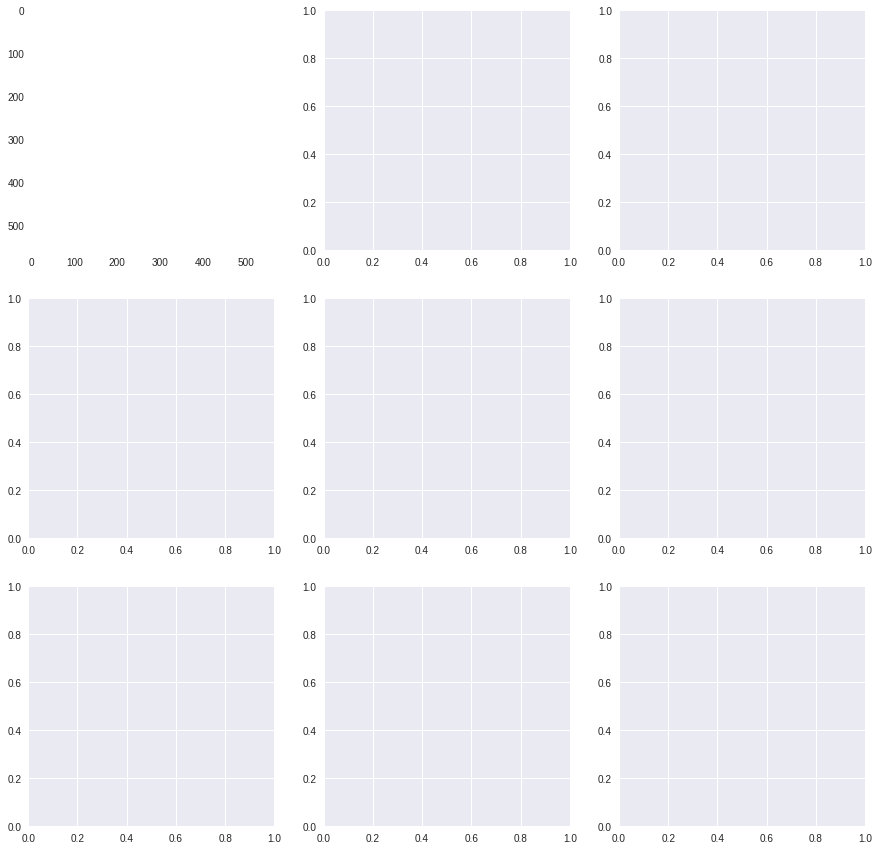

In [113]:
pred_arr = input_data[5]
pred_arr = np.expand_dims(pred_arr, axis=0)
print(pred_arr.shape)
outp = model.predict(pred_arr, batch_size=1)
#print(outp)
print(outp.shape)
outp = outp.reshape((560,560,1))
print(outp.shape)
outp = outp.reshape((560,560))
show_images([outp])